In [109]:
import scqubits as scq
import numpy as np
import scipy as sci
from functions import *
sdim = dims =  6
os_dim = 4
d1 = d2 = 6
EL1 = EL2 = 0.4
def fsof(flux1, flux2, phi3, ELc,ECc):
    # phi3 = 0.4
    Ecs = 0.2*2*np.pi
    Ecs = ECc*Ecs/(ECc+Ecs)
    Hs, phis, charge_op = SNAILL(phi3, 0.2, 3, 50*2*np.pi, Ecs,sdim,ELc)
    
    
    H1,H2,phi1,phi2 = fluxonium(flux1,flux2,EL1,EL2,d1,d2)
    # Identity matrices for tensor products
    If1 = np.identity(d1)
    If2 = np.identity(d2)
    Is = np.identity(dims)
    Io = np.identity(os_dim)
    # Oscillator Hamiltonian
    ad = creation(os_dim)
    a = annihilation(os_dim)
    Ho = np.sqrt(8*ECc*ELc) * ad @ a
    phi_os = (a + ad)*(2*ECc/ELc)**0.25

    # Tensor product expansions
    Hs = np.kron(np.kron(np.kron(Hs, Io), If2), If1)
    Ho = np.kron(np.kron(np.kron(Is, Ho), If2), If1)
    H2 = np.kron(np.kron(np.kron(Is, Io), H2), If1)
    H1 = np.kron(np.kron(np.kron(Is, Io), If2), H1)

    H_int1 = -EL2*2*np.pi * np.kron(np.kron(np.kron(phis, Io), If2),phi1)/2
    H_int2 = EL1*2*np.pi * np.kron(np.kron(np.kron(phis, Io), phi2), If1)/2
    H_int3 = -EL2*2*np.pi * np.kron(np.kron(np.kron(Is, phi_os), If2), phi1)/2
    H_int4 = -EL1*2*np.pi * np.kron(np.kron(np.kron(Is, phi_os), phi2), If1)/2

    # Complete Hamiltonian
    H = Hs+ Ho + H1 + H2 + H_int1 +H_int2 + H_int3 + H_int4
    # Charge operators for later transformations
    hc1 = np.kron(np.kron(np.kron(charge_op, Io), If1), If2)
    hc2 = np.kron(np.kron(np.kron(Is, -1j * (a - ad)), If1), If2)

    # Diagonalize the Hamiltonian
    energy0, U = np.linalg.eigh(H)
    energy0, U = sort_eigenpairs(energy0, U)
    energy0 -= energy0[0]
    Ud = U.T.conjugate()
    H = np.diag(energy0)
    hc1 = Ud @ hc1 @ U
    hc2 = Ud @ hc2 @ U
    return energy0, hc1, hc2


In [89]:
def fsof2(flux1, flux2, phi3, ELc,ECc,fluxsh1,fluxsh2):
    Ecs = 0.2*2*np.pi
    Ecs = ECc*Ecs/(ECc+Ecs)
    Hs, phis, charge_op = SNAILL(phi3, 0.2, 3, 50*2*np.pi, Ecs,sdim,ELc)
    
    H1,H2,phi1,phi2 = fluxonium(flux1,flux2,EL1,EL2,d1,d2)
    fluxsh1 = fluxsh1*2*np.pi
    fluxsh2 = fluxsh2*2*np.pi

    # Identity matrices for tensor products
    If1 = np.identity(d1)
    If2 = np.identity(d2)
    Is = np.identity(dims)
    Io = np.identity(os_dim)
    # Oscillator Hamiltonian
    ad = creation(os_dim)
    a = annihilation(os_dim)
    Ho = np.sqrt(8*ECc*ELc) * ad @ a
    phi_os = (a + ad)*(2*ECc/ELc)**0.25

    # Tensor product expansions
    Hs = np.kron(np.kron(np.kron(Hs, Io), If2), If1)
    Ho = np.kron(np.kron(np.kron(Is, Ho), If2), If1)
    H2 = np.kron(np.kron(np.kron(Is, Io), H2), If1)
    H1 = np.kron(np.kron(np.kron(Is, Io), If2), H1)

    H_int1 = -EL2/2*2*np.pi * np.kron(np.kron(np.kron(phis, Io), If2),phi1-fluxsh1*If1)
    H_int2 = EL1/2*2*np.pi * np.kron(np.kron(np.kron(phis, Io), phi2-fluxsh2*If2), If1)
    H_int3 = -EL2/2*2*np.pi * np.kron(np.kron(np.kron(Is, phi_os), If2), phi1-fluxsh1*If1)
    H_int4 = -EL1/2*2*np.pi * np.kron(np.kron(np.kron(Is, phi_os), phi2-fluxsh2*If2), If1)
    
    H_int5 = fluxsh1*EL2*2*np.pi/2*(-2*np.kron(np.kron(np.kron(Is, Io), If2),phi1))
    H_int6 = fluxsh2*EL2*2*np.pi/2*(-2*np.kron(np.kron(np.kron(Is, Io), phi2),If1))
    # Complete Hamiltonian
    H = Hs+ Ho + H1 + H2 + H_int1 +H_int2 + H_int3 + H_int4 + H_int5 + H_int6
    return Hs+ Ho + H1 + H2 , H_int1 +H_int2 + H_int3 + H_int4 + H_int5 + H_int6

In [90]:
from scipy.optimize import minimize
def objective_function(x, phi3,ELc,ECc):
    fluxsh1, fluxsh2 = x
    flux1 = 0.5
    flux2 = 0.5
    H0, V = fsof2(flux1, flux2, phi3,ELc,ECc, fluxsh1, fluxsh2)
    H0, V = shuffle_matrices(H0, V)
    swt_result = swt_subspace(H0, V, [0, 1, 2, 3])
    
    # Sum the relevant submatrices
    sum_matrix = sum(swt_result[1][i][0:6, 0:6] for i in range(4))
    
    # Calculate specific matrix elements
    element_sum = (np.abs(sum_matrix[0, 1]) + np.abs(sum_matrix[0, 2]) + 
                   np.abs(sum_matrix[1, 3]) + np.abs(sum_matrix[2, 3]))
    
    return element_sum

# Function to perform optimization for a given phi3
def optimize_for_phi3(phi3,ELc,ECc):
    # Initial guess
    Ecs = 0.2*2*np.pi
    Ecs = ECc*Ecs/(ECc+Ecs)
    ws,g3,phi_c,c2 = SNAILL_paras(phi3, 0.2, 3, 30*2*np.pi, Ecs,sdim,ELc)
    guess = (3*g3/ws*phi_c/2/np.pi)[0]
    x0 = [guess, -guess]  # Starting point in the middle of your range

    # Bounds for the optimization
    bounds = [(guess-1e-3, guess+1e-3),(-guess-1e-3, -guess+1e-3)]

    # Perform the optimization
    result = minimize(objective_function, x0, args=(phi3,ELc,ECc), method='Nelder-Mead', bounds=bounds)
    
    return result

In [91]:
ELc = 1e10*2*np.pi
ECc = 5*2*np.pi
Ecs = 0.2*2*np.pi
Ecs = ECc*Ecs/(ECc+Ecs)
phi3 = 0.4
optimize_for_phi3(phi3, ELc,ECc)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.05617745806959878
             x: [ 4.843e-03 -4.843e-03]
           nit: 12
          nfev: 21
 final_simplex: (array([[ 4.843e-03, -4.843e-03],
                       [ 4.843e-03, -4.843e-03],
                       [ 4.843e-03, -4.843e-03]]), array([ 5.618e-02,  5.618e-02,  5.618e-02]))

In [99]:
ws,g3,phi_c,c2 = SNAILL_paras(0.41, 0.2, 3, 60*2*np.pi, 0.2*2*np.pi,sdim, 5*2*np.pi)

In [104]:
Ej = 60*2*np.pi
ELc = (2-c2) * 60*2*np.pi
ELc = 1e10*2*np.pi

In [105]:
phi3 = 0.4
result = optimize_for_phi3(phi3,ELc,5*2*np.pi)
fluxsh1,fluxsh2 = result.x

flux1 = 0.5 + fluxsh1
flux2 = 0.5 + fluxsh2
energy = fsof(flux1, flux2, phi3, ELc,ECc)[0]
energy -= energy[0]
energy = np.sort(energy)
zz = (energy[3]-energy[2] - energy[1])/2/np.pi
flux1 = flux2 = 0.5
H0, V = fsof2(flux1, flux2, 0.4,ELc,ECc, fluxsh1, fluxsh2)
H0, V = shuffle_matrices(H0, V)
swt_result = swt_subspace(H0, V, [0, 1, 2, 3])
sum_matrix = sum(swt_result[1][i][0:4, 0:4] for i in range(4))
JJ = [(sum_matrix/2/np.pi)[1,2],(sum_matrix/2/np.pi)[0,3]]

In [113]:
from joblib import Parallel, delayed

# Define the parameter range for ELc
ELc_range = np.linspace(10 * 2 * np.pi, 100 * 2 * np.pi, 50)

# Function to process each ELc value
def process_ELc(ELc):
    result = optimize_for_phi3(phi3, ELc, 5 * 2 * np.pi)
    fluxsh1, fluxsh2 = result.x

    flux1 = 0.5 + fluxsh1
    flux2 = 0.5 + fluxsh2
    energy = fsof(flux1, flux2, phi3, ELc, ECc)[0]
    energy -= energy[0]
    energy = np.sort(energy)
    zz = (energy[3] - energy[2] - energy[1]) / (2 * np.pi)

    flux1 = flux2 = 0.5
    H0, V = fsof2(flux1, flux2, 0.4, ELc, ECc, fluxsh1, fluxsh2)
    H0, V = shuffle_matrices(H0, V)
    swt_result = swt_subspace(H0, V, [0, 1, 2, 3])
    sum_matrix = sum(swt_result[1][i][0:4, 0:4] for i in range(4))
    JJ = [(sum_matrix / (2 * np.pi))[1, 2], (sum_matrix / (2 * np.pi))[0, 3]]

    return zz, JJ

# Perform the sweeping in parallel
results = Parallel(n_jobs=-1)(delayed(process_ELc)(ELc) for ELc in ELc_range)

# Extract zz and JJ values from results
zz_values = np.array([r[0] for r in results])
JJ_values = np.array([r[1] for r in results])

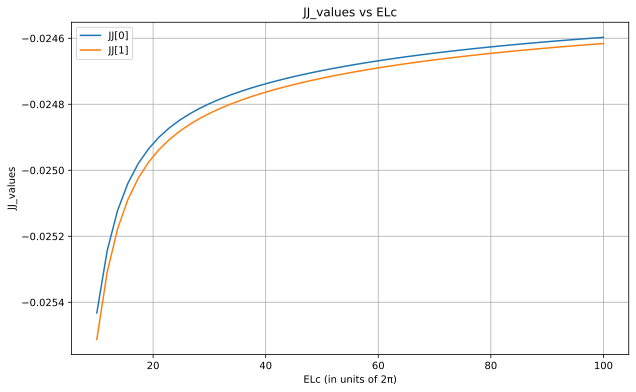

In [114]:
# Plotting JJ_values vs ELc
plt.figure(figsize=(10, 6))
plt.plot(ELc_range / (2 * np.pi), JJ_values[:, 0], label='JJ[0]')
plt.plot(ELc_range / (2 * np.pi), JJ_values[:, 1], label='JJ[1]')
plt.xlabel('ELc (in units of 2π)')
plt.ylabel('JJ_values')
plt.title('JJ_values vs ELc')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plotting JJ_values vs ELc
plt.figure(figsize=(10, 6))
plt.plot(ELc_range / (2 * np.pi), JJ_values[:, 0], label='JJ[0]')
plt.plot(ELc_range / (2 * np.pi), JJ_values[:, 1], label='JJ[1]')
plt.xlabel('ELc (in units of 2π)')
plt.ylabel('JJ_values')
plt.title('JJ_values vs ELc')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# process_point(0.4, 7*2*np.pi)

In [31]:
from joblib import Parallel, delayed
def process_point(phi3, ELc):
    result = optimize_for_phi3(phi3)
    fluxsh1, fluxsh2 = result.x

    ECc = 0.2 * 2 * np.pi
    flux1 = 0.5 + fluxsh1
    flux2 = 0.5 + fluxsh2
    energy = fsof(flux1, flux2, phi3, ELc, ECc)[0]
    energy -= energy[0]
    energy = np.sort(energy)
    zz = (energy[3] - energy[2] - energy[1]) / (2 * np.pi)

    flux1 = flux2 = 0.5
    H0, V = fsof2(flux1, flux2, phi3, ELc, ECc, fluxsh1, fluxsh2)
    H0, V = shuffle_matrices(H0, V)
    swt_result = swt_subspace(H0, V, [0, 1, 2, 3])
    sum_matrix = sum(swt_result[1][i][0:4, 0:4] for i in range(4))
    JJ = [(sum_matrix / (2 * np.pi))[1, 2], (sum_matrix / (2 * np.pi))[0, 3]]

    return zz, JJ[0]

# Define the parameter ranges
phi3_range = np.linspace(0.35, 0.42, 5)
ELc_range = np.linspace(7 * 2 * np.pi, 9 * 2 * np.pi, 10)

# Create a mesh grid for plotting
Phi3, ELcs = np.meshgrid(phi3_range, ELc_range)

# Parallelize the computation
results = Parallel(n_jobs=-1)(delayed(process_point)(phi3, ELc) 
                              for phi3, ELc in zip(Phi3.flatten(), ELcs.flatten()))


In [32]:
results = np.array(results)

In [33]:
results.shape

(50, 2)

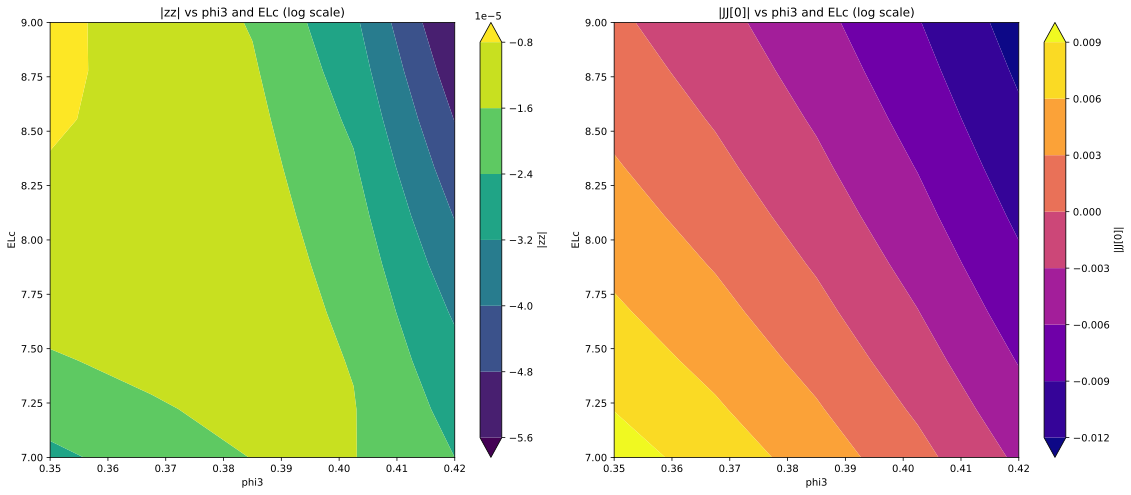

In [34]:
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already defined phi3_range, ELc_range, and calculated results

Phi3, ELc = np.meshgrid(phi3_range, ELc_range)
ZZ = np.array([r[0] for r in results]).reshape(Phi3.shape)
JJ0 = np.array([r[1] for r in results]).reshape(Phi3.shape)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))



# Plot zz vs phi3, ELc with logarithmic color scale
contour1 = ax1.contourf(Phi3, ELc/2/np.pi, ZZ, 

                        cmap='viridis', extend='both')
ax1.set_xlabel('phi3')
ax1.set_ylabel('ELc')
ax1.set_title('|zz| vs phi3 and ELc (log scale)')
cbar1 = fig.colorbar(contour1, ax=ax1, label='|zz|', extend='both')
cbar1.ax.set_yscale('log')
cbar1.ax.yaxis.set_major_formatter(plt.ScalarFormatter())
cbar1.ax.yaxis.set_minor_formatter(plt.ScalarFormatter())

# Plot JJ[0] vs phi3, ELc with logarithmic color scale
contour2 = ax2.contourf(Phi3, ELc/2/np.pi, JJ0, 
                        cmap='plasma', extend='both')
ax2.set_xlabel('phi3')
ax2.set_ylabel('ELc')
ax2.set_title('|JJ[0]| vs phi3 and ELc (log scale)')
cbar2 = fig.colorbar(contour2, ax=ax2, label='|JJ[0]|', extend='both')
cbar2.ax.yaxis.set_major_formatter(plt.ScalarFormatter())
cbar2.ax.yaxis.set_minor_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.show()

In [26]:
ZZ

array([[-1.04863274e-05, -9.53146898e-06, -9.94509685e-06,
        -1.61565739e-05, -3.20351918e-05],
       [-8.55226023e-06, -8.61208751e-06, -1.03050828e-05,
        -1.81522780e-05, -3.61084580e-05],
       [-7.19326053e-06, -8.19286711e-06, -1.10714463e-05,
        -2.04355714e-05, -4.03199745e-05],
       [-6.30228669e-06, -8.17457922e-06, -1.21546882e-05,
        -2.29291909e-05, -4.46077394e-05],
       [-5.79272684e-06, -8.47739328e-06, -1.34834279e-05,
        -2.55723914e-05, -4.89242857e-05],
       [-5.59419055e-06, -9.03683078e-06, -1.50005582e-05,
        -2.83173515e-05, -5.32333955e-05],
       [-5.64924028e-06, -9.80063016e-06, -1.66602753e-05,
        -3.11264084e-05, -5.75075881e-05],
       [-5.91083641e-06, -1.07263014e-05, -1.84257686e-05,
        -3.39699174e-05, -6.17261884e-05],
       [-6.34032771e-06, -1.17792074e-05, -2.02674148e-05,
        -3.68245856e-05, -6.58738345e-05],
       [-6.90586159e-06, -1.29310498e-05, -2.21613573e-05,
        -3.96721688e-05

In [18]:
JJ0

array([[ 0.00999029,  0.00743134,  0.00434122,  0.00061347, -0.00382347],
       [ 0.00865232,  0.00609338,  0.00300328, -0.00072444, -0.00516133],
       [ 0.00739544,  0.00483651,  0.00174642, -0.00198127, -0.00641811],
       [ 0.00621249,  0.00365357,  0.0005635 , -0.00316415, -0.00760095],
       [ 0.00509715,  0.00253824, -0.00055181, -0.00427944, -0.00871619],
       [ 0.00404379,  0.00148489, -0.00160514, -0.00533274, -0.00976945],
       [ 0.00304738,  0.00048849, -0.00260152, -0.00632909, -0.01076575],
       [ 0.00210343, -0.00045544, -0.00354544, -0.00727298, -0.0117096 ],
       [ 0.00120791, -0.00135095, -0.00444093, -0.00816844, -0.01260502],
       [ 0.00035719, -0.00220166, -0.00529162, -0.00901911, -0.01345565]])

In [22]:
len(Phi3)

10